In [38]:
import time

import numpy as np

%matplotlib inline
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
import seaborn

seaborn.set()

In [64]:
N_CLI = 20 * 1000
N_STY = 2 * 1000

clients = np.random.normal(0, 1, size=(N_CLI, 10))
stylists = np.random.normal(0, 1, size=(N_STY, 10))
aff = np.matmul(stylists, clients.T)

In [65]:
def place_bids(reward_matrix, prices):
    bids = np.zeros_like(reward_matrix, dtype=np.int8)
    rewards = reward_matrix - prices
    for i in range(reward_matrix.shape[1]):
        sty_index = i % reward_matrix.shape[0]
        best_fix_index = np.argmax(rewards[sty_index])
        bids[sty_index, best_fix_index] = 1
        rewards[sty_index, best_fix_index] = -np.inf
    return bids


def shadow_prices(reward_matrix, niter=100, lr_decay_scale=10.0):
    print "Finding shadow prices for {} stylists x {} fixes".format(
        *reward_matrix.shape)
    prices = np.ones(reward_matrix.shape[1])
    mark = time.time()

    for i in range(niter):
        learn_rate = 1.0 / ((i / lr_decay_scale) + 2)
        bids = place_bids(reward_matrix, prices)
        price_gradient = 1.0 - bids.sum(axis=0)
        prices = np.maximum(0, prices - learn_rate * price_gradient)
        if (i + 1) % 10 == 0:
            log_summary(mark, i, learn_rate, bids, prices)

    return prices


def log_summary(mark, i, learn_rate, bids, prices):
    print " ".join([
        "i={:03d}".format(i + 1),
        "elapsed={:.1f}".format(time.time() - mark),
        "lr={:.3f}".format(learn_rate),
        "unwanted={:05d}".format((bids.sum(axis=0) == 0).sum()),
        "avgprice={:.2f}".format(np.mean(prices))])

In [66]:
pshadow = shadow_prices(aff, niter=300)

Finding shadow prices for 2000 stylists x 20000 fixes
i=010 elapsed=7.7 lr=0.345 unwanted=07572 avgprice=1.87
i=020 elapsed=14.8 lr=0.256 unwanted=05291 avgprice=2.21
i=030 elapsed=21.0 lr=0.204 unwanted=04258 avgprice=2.37
i=040 elapsed=26.8 lr=0.169 unwanted=03585 avgprice=2.47
i=050 elapsed=36.2 lr=0.145 unwanted=03173 avgprice=2.54
i=060 elapsed=44.4 lr=0.127 unwanted=02819 avgprice=2.59
i=070 elapsed=50.7 lr=0.112 unwanted=02544 avgprice=2.64
i=080 elapsed=56.6 lr=0.101 unwanted=02383 avgprice=2.67
i=090 elapsed=62.4 lr=0.092 unwanted=02180 avgprice=2.70
i=100 elapsed=68.3 lr=0.084 unwanted=02049 avgprice=2.72
i=110 elapsed=74.4 lr=0.078 unwanted=01969 avgprice=2.74
i=120 elapsed=82.5 lr=0.072 unwanted=01859 avgprice=2.76
i=130 elapsed=88.5 lr=0.067 unwanted=01750 avgprice=2.78
i=140 elapsed=94.4 lr=0.063 unwanted=01673 avgprice=2.79
i=150 elapsed=100.2 lr=0.059 unwanted=01628 avgprice=2.81
i=160 elapsed=106.1 lr=0.056 unwanted=01583 avgprice=2.82
i=170 elapsed=113.0 lr=0.053 unwa

In [72]:
class DoublyIndexedAssignment(object):
    
    def __init__(self, n):
        indices = np.arange(n)
        np.random.shuffle(indices)
        self.buyer_to_item = dict(zip(np.arange(n), indices))
        self.item_to_buyer = dict(zip(indices, np.arange(n)))
        
    def switch(self, buyer_ix, item_ix):
        bumped_buyer_ix = self.item_to_buyer[item_ix]
        bumped_item_ix = self.buyer_to_item[buyer_ix]
        
        self.buyer_to_item[buyer_ix] = item_ix
        self.item_to_buyer[item_ix] = buyer_ix
        
        self.buyer_to_item[bumped_buyer_ix] = bumped_item_ix
        self.item_to_buyer[bumped_item_ix] = bumped_buyer_ix
        
        return bumped_buyer_ix, bumped_item_ix

        
def auction_prices(reward_matrix, eta=0.05, tol=0.99, prices=None):
    mark = time.time()
    n_buyer, n_item = reward_matrix.shape
    if prices is None:
        prices = np.zeros(n_item)
    else:
        prices = np.copy(prices)
    happy = np.zeros(n_item, dtype=np.bool)
    assignments = DoublyIndexedAssignment(n_item)
    index = np.arange(n_item)
    niter = 0
    
    for buyer_ix in index:
        value = reward_matrix[buyer_ix % n_buyer] - prices
        true_value = value[assignments.buyer_to_item[buyer_ix]]
        if (value.max() - true_value) < eta:
            happy[buyer_ix] = 1
    
    while np.mean(happy) < tol:
        buyer_ix = np.random.choice(index[~happy])
        value = reward_matrix[buyer_ix % n_buyer] - prices
        best_value_ix, runner_up_value_ix = np.argpartition(
            -value, 2)[:2]
        
        best_value = value[best_value_ix]
        runner_up_value = value[runner_up_value_ix]
        prices[best_value_ix] += eta + best_value - runner_up_value
        
        bumped_buyer_ix, bumped_item_ix = assignments.switch(
            buyer_ix, best_value_ix)
        happy[buyer_ix] = 1

        bumped_value = reward_matrix[bumped_buyer_ix % n_buyer] - prices
        bumped_best_value = np.max(bumped_value)
        bumped_true_value = bumped_value[bumped_item_ix]
        bumped_value_gap = bumped_best_value - bumped_true_value
        happy[bumped_buyer_ix] = bumped_value_gap <= eta
        
        if niter % 10000 == 0:
            print "".join(str(x) for x in [
                "i=", niter,
                " elapsed=", round((time.time() - mark), 1),
                " avgprice=", np.mean(prices).round(2),
                " happy=", np.mean(happy).round(4)])
        niter += 1
        
    prices -= prices.min()
    return prices


def eta_scaling(reward_matrix, eta_zero=1.0, niter=5, scale_factor=2.0):
    prices = None
    eta = np.copy(eta_zero)
    mark = time.time()
    
    for i in range(niter):
        print "\n --- Scaling iteration", i, "eta =", round(eta, 5)
        tol = 1.0 if i == (niter - 1) else 0.99
        prices = auction_prices(
            reward_matrix,
            eta=eta,
            tol=tol,
            prices=prices)
        eta /= scale_factor
    
    print "\n completed in {:.1f} seconds".format(time.time() - mark)
    return prices

In [73]:
pauction = eta_scaling(aff, eta_zero=1.0, niter=5, scale_factor=np.sqrt(10))


 --- Scaling iteration 0 eta = 1.0
i=0 elapsed=0.7 avgprice=0.0 happy=0.0002
i=10000 elapsed=3.8 avgprice=0.64 happy=0.3206
i=20000 elapsed=7.7 avgprice=1.21 happy=0.5413
i=30000 elapsed=11.3 avgprice=1.77 happy=0.7054
i=40000 elapsed=14.5 avgprice=2.32 happy=0.8244
i=50000 elapsed=17.2 avgprice=2.86 happy=0.9096
i=60000 elapsed=19.5 avgprice=3.4 happy=0.9648

 --- Scaling iteration 1 eta = 0.31623
i=0 elapsed=0.7 avgprice=3.89 happy=0.0004
i=10000 elapsed=3.9 avgprice=4.09 happy=0.4274
i=20000 elapsed=7.6 avgprice=4.27 happy=0.67
i=30000 elapsed=10.9 avgprice=4.44 happy=0.8431
i=40000 elapsed=13.4 avgprice=4.62 happy=0.9488
i=50000 elapsed=15.5 avgprice=4.79 happy=0.9884

 --- Scaling iteration 2 eta = 0.1
i=0 elapsed=0.7 avgprice=4.47 happy=0.0001
i=10000 elapsed=3.9 avgprice=4.53 happy=0.4314
i=20000 elapsed=7.6 avgprice=4.59 happy=0.6806
i=30000 elapsed=10.8 avgprice=4.65 happy=0.85
i=40000 elapsed=13.3 avgprice=4.7 happy=0.9424
i=50000 elapsed=15.4 avgprice=4.76 happy=0.98

 --- 

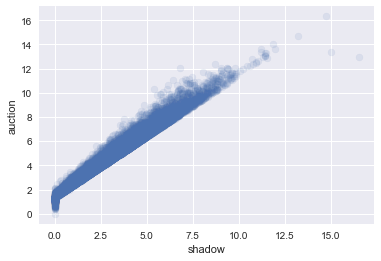

In [74]:
figsize(6, 4)
plt.scatter(pshadow, pauction, alpha = 0.1)
plt.xlabel("shadow")
plt.ylabel("auction")
plt.show()

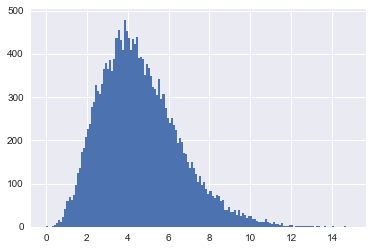

In [75]:
plt.hist(pauction, bins=np.arange(0, 15, 0.1))
plt.show()